In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as date
from datetime import timedelta
import matplotlib.pyplot as plt
from utils.api import *
from utils.price_analysis import *
from utils.utils import *
from utils.wallet_analysis import * 
from scipy import stats
# from qbstyles import mpl_style


In [2]:
# plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pacoty.mplstyle')
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

plt.rc('figure', figsize=(8,5))
plt.rc('figure', dpi=150)
plt.rcParams['axes.grid'] = True
# mpl_style(dark=True)


#### Datasets

Our data is in three different sources:

(1) `metadata.py` stores the token names, airdrop dates, allocation sizes, and elligibility types. We reference an elligibility type of 0 as "widespread" and 1 as "core users". \
(2) `/wallet-data` has a corresponding csv file for each token (names are all coingecko ids) with wallet data on each recipient of the airdrop. Each table has a recipient address, the timestamp for their first claim, the amount claimed in total, how many transactions they used to claim, the amount they sold, and the amount they bought. \
(3) `/price-data` stores market data 60 days after TGE for each token. The structure and naming convention is identical to (2). 

We pull all of these sources in as objects. 

In [3]:
from metadata import metadata
all_token_ids = metadata.keys()
wallet_data = compile_directory_to_object('dune_walletdata')
market_data_index = compile_directory_to_object('price_data2')

DescribeResult(nobs=40, minmax=(0.24, 67.0), mean=13.916, variance=286.86541435897436, skewness=1.8748235081820004, kurtosis=2.6099254053336045)


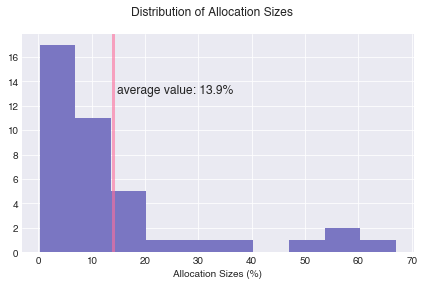

In [4]:
allocations = np.array([metadata[t]["alloc_size"] for t in metadata]) * 100
allocations.sort()
avg = allocations.mean()
print(stats.describe(allocations))

plt.hist(allocations, bins='auto') # non-normal -> use doane estimator
plt.xlabel('Allocation Sizes (%)')
plt.suptitle("Distribution of Allocation Sizes")
plt.axvline(avg, color='C1', label="Average", lw=3)
plt.text(avg + 0.8, 13, f"average value: {round(avg, 1)}%", fontsize='large')
plt.tight_layout()

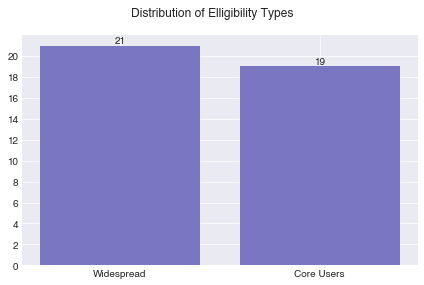

In [5]:
widespread = sum([1 for t in metadata if metadata[t]['eligibility'] == 0])
core = sum([1 for t in metadata if metadata[t]['eligibility'] == 1])


bars = plt.bar(['Widespread', 'Core Users'], [widespread, core])
plt.yticks(range(0, 21, 2))
plt.suptitle("Distribution of Elligibility Types")

for bar, value in zip(bars, [widespread, core]):
    plt.text(bar.get_x() + bar.get_width() / 2, 
             bar.get_height(), 
             str(value), 
             ha='center', 
             va='bottom')

plt.tight_layout()

#### Bucket Comparison

We split the data into different buckets depending on design choices.

(1) % Of Supply Airdropped. The average value of ~14% is skewed by some large outliers, so we instead use 10% as a number that we deem reasonable as a separator between "small" and "large" airdrop allocations. \
(2) Eligibility. This is a straight forward category between Widespread and Core Users.

In [6]:
# split allocation supply buckets
larger_alloc, smaller_alloc = [], []
widespread = [t for t in metadata if metadata[t]["eligibility"] == 0]
core_users = [t for t in metadata if metadata[t]["eligibility"] == 1]

for t in metadata.keys():
    if metadata[t]["alloc_size"] >= 0.1:
        larger_alloc.append(t)
    else:
        smaller_alloc.append(t)

print(f"{len(larger_alloc)} larger allocation airdrops. \n {larger_alloc}")
print(f"{len(smaller_alloc)} smaller allocation airdrops. \n {smaller_alloc}")
print("===================================================================================================")
print(f"{len(widespread)} widespread airdrops. \n {widespread}")
print(f"{len(core_users)} core user airdrops. \n {core_users}")

19 larger allocation airdrops. 
 ['jito-governance-token', 'ampleforth', 'apecoin', 'arbitrum', 'blur', 'botto', 'cow-protocol', 'dappradar', 'dydx', 'ethereum-name-service', 'forefront', 'gas-dao', 'gitcoin', 'giveth', 'looksrare', 'shapeshift-fox-token', 'uniswap', 'velodrome-finance', 'x2y2']
21 smaller allocation airdrops. 
 ['pyth-network', 'stepn', '1inch', 'arkham', 'benddao', 'ellipsis', 'forta', 'gearbox', 'hop-protocol', 'notional-finance', 'optimism', 'paladin', 'pangolin', 'pooltogether', 'project-galaxy', 'ribbon-finance', 'snowswap', 'sudoswap', 'thales', 'tornado-cash', 'value-liquidity']
21 widespread airdrops. 
 ['pyth-network', 'jito-governance-token', '1inch', 'blur', 'botto', 'dappradar', 'ellipsis', 'forefront', 'forta', 'gas-dao', 'gearbox', 'looksrare', 'optimism', 'paladin', 'project-galaxy', 'shapeshift-fox-token', 'sudoswap', 'thales', 'uniswap', 'velodrome-finance', 'x2y2']
19 core user airdrops. 
 ['stepn', 'ampleforth', 'apecoin', 'arbitrum', 'arkham', 'ben

In [7]:
# Get all possible combinations of buckets
smaller_widespread, larger_widespread = [], []
smaller_core, larger_core = [], []

for t in smaller_alloc:
    if t in widespread:
        smaller_widespread.append(t)
    else:
        smaller_core.append(t)
for t in larger_alloc:
    if t in widespread:
        larger_widespread.append(t)
    else:
        larger_core.append(t)


print(f"Smaller Alloc + Widespread \n {smaller_widespread}")
print(f"Larger Alloc + Widespread \n {larger_widespread}")
print(f"Smaller Alloc + Core Users \n {smaller_core}")
print(f"Larger Alloc + Core Users \n {larger_core}")

Smaller Alloc + Widespread 
 ['pyth-network', '1inch', 'ellipsis', 'forta', 'gearbox', 'optimism', 'paladin', 'project-galaxy', 'sudoswap', 'thales']
Larger Alloc + Widespread 
 ['jito-governance-token', 'blur', 'botto', 'dappradar', 'forefront', 'gas-dao', 'looksrare', 'shapeshift-fox-token', 'uniswap', 'velodrome-finance', 'x2y2']
Smaller Alloc + Core Users 
 ['stepn', 'arkham', 'benddao', 'hop-protocol', 'notional-finance', 'pangolin', 'pooltogether', 'ribbon-finance', 'snowswap', 'tornado-cash', 'value-liquidity']
Larger Alloc + Core Users 
 ['ampleforth', 'apecoin', 'arbitrum', 'cow-protocol', 'dydx', 'ethereum-name-service', 'gitcoin', 'giveth']


#### Price and Volatility Analysis
We look at the price performance over 15, 30, and 45 days for each set of buckets. 

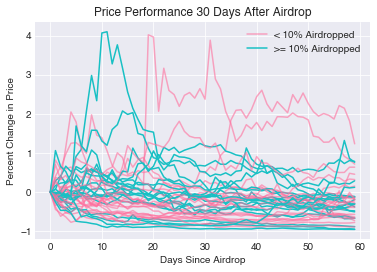

In [8]:
# plt.figure(figsize=(15, 12))

W = 60

plt.title("Price Performance 30 Days After Airdrop")
plt.xlabel("Days Since Airdrop")
plt.ylabel("Percent Change in Price")
# Allocation Size Bucket - Plot
for token in all_token_ids:
    change_data = list(market_data_index[token]['pct_change_price'])[:W]
    color = 'C1' if token in smaller_alloc else 'C3'

    plt.plot(change_data, color=color)


plt.legend(["< 10% Airdropped", '>= 10% Airdropped'])

In [9]:
change_obj = {'token': [], 'week': [], 'month': [], 'two_months': []}
change_dict = dict()
for token in all_token_ids:
    change_dict[token] = dict()
    for W in [6, 29, 59]:
        change = market_data_index[token]['pct_change_price'][W]
        change_dict[token][str(W)] = change

for token in change_dict.keys():
    change_obj['token'].append(token)
    change_obj['week'].append(change_dict[token]['6'])
    change_obj['month'].append(change_dict[token]['29'])
    change_obj['two_months'].append(change_dict[token]['59'])

changes = pd.DataFrame(change_obj)

changes.to_csv('price_changes.csv')

In [10]:
larger_alloc_sts = get_token_price_stats(larger_alloc, market_data_index, W)
smaller_alloc_sts = get_token_price_stats(smaller_alloc, market_data_index, W)

larger_alloc_agg = aggregrate_price_stats(larger_alloc_sts)
smaller_alloc_agg = aggregrate_price_stats(smaller_alloc_sts)

print(f"Larger Allocation Bucket \n Price Change: {larger_alloc_agg['change']} Volatility: {larger_alloc_agg['variance']}")
print("=================================================================================")
print(f"Smaller Allocation Bucket \n Price Change: {smaller_alloc_agg['change']} Volatility: {smaller_alloc_agg['variance']}")


Larger Allocation Bucket 
 Price Change: -0.2594246228072058 Volatility: 42.682652150546225
Smaller Allocation Bucket 
 Price Change: -0.10762783941026206 Volatility: 36.83925243389593


In [11]:
widespread_sts = get_token_price_stats(widespread, market_data_index, W)
core_users_sts = get_token_price_stats(core_users, market_data_index, W)

widespread_agg = aggregrate_price_stats(widespread_sts)
core_users_agg = aggregrate_price_stats(core_users_sts)

print(f"Widespread Bucket \n Price Change: {widespread_agg['change']} Volatility: {widespread_agg['variance']}")
print("=================================================================================")
print(f"Core Users Bucket \n Price Change: {core_users_agg['change']} Volatility: {core_users_agg['variance']}")

Widespread Bucket 
 Price Change: -0.16783424000192101 Volatility: 43.9026838208205
Core Users Bucket 
 Price Change: -0.1928807063637933 Volatility: 34.875701670261186


In [12]:
larger_widespread_sts = get_token_price_stats(larger_widespread, market_data_index, W)
smaller_widespread_sts = get_token_price_stats(smaller_widespread, market_data_index, W)
larger_core_sts = get_token_price_stats(larger_core, market_data_index, W)
smaller_core_sts = get_token_price_stats(smaller_core, market_data_index, W)

larger_widespread_agg = aggregrate_price_stats(larger_widespread_sts)
smaller_widespread_agg = aggregrate_price_stats(smaller_widespread_sts)
larger_core_agg = aggregrate_price_stats(larger_core_sts)
smaller_core_agg = aggregrate_price_stats(smaller_core_sts)

print(f"Widespread + Larger \n Price Change: {larger_widespread_agg['change']} Volatility: {larger_widespread_agg['variance']}")
print("=================================================================================")
print(f"Widespread + Smaller \n Price Change: {smaller_widespread_agg['change']} Volatility: {smaller_widespread_agg['variance']}")
print("=================================================================================")
print(f"Core + Larger \n Price Change: {larger_core_agg['change']} Volatility: {larger_core_agg['variance']}")
print("=================================================================================")
print(f"Core + Smaller \n Price Change: {smaller_core_agg['change']} Volatility: {smaller_core_agg['variance']}")

Widespread + Larger 
 Price Change: -0.2361835814952671 Volatility: 53.244172370638104
Widespread + Smaller 
 Price Change: -0.09264996435924029 Volatility: 33.62704641602111
Core + Larger 
 Price Change: -0.29138105461112146 Volatility: 28.16056184791989
Core + Smaller 
 Price Change: -0.1212440894566455 Volatility: 39.759439722873054


In [13]:
larger_widespread_tmseries = aggregated_time_series(larger_widespread, market_data_index, 60, 1)
smaller_widespread_tmseries = aggregated_time_series(smaller_widespread, market_data_index, 60, 1)
larger_core_tmseries = aggregated_time_series(larger_core, market_data_index, 60, 1)
smaller_core_tmseries = aggregated_time_series(smaller_core, market_data_index, 60, 1)

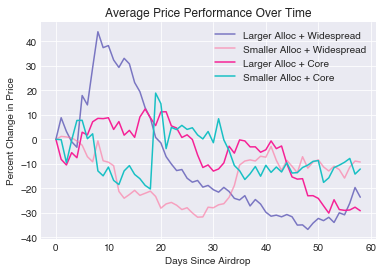

In [14]:
plt.plot([x * 100 for x in larger_widespread_tmseries["price"]])
plt.plot([x * 100 for x in smaller_widespread_tmseries["price"]])
plt.plot([x * 100 for x in larger_core_tmseries["price"]])
plt.plot([x * 100 for x in smaller_core_tmseries["price"]])

plt.title("Average Price Performance Over Time")
plt.xlabel("Days Since Airdrop")
plt.ylabel("Percent Change in Price")

plt.legend(["Larger Alloc + Widespread", 'Smaller Alloc + Widespread','Larger Alloc + Core', 'Smaller Alloc + Core'])

#### Wallet Analysis
For each of the buckets, we analyze the actions of airdrop recipients 30 days after claim. We are interested in whether or not users held, sold, or bought more of the token after receiving the airdrop. 

Additionally, we further split the analysis on quartiles of amounts claimed. Is there a difference in actions between the top and bottom 25% of airdrop claimants?

In [15]:
holding_stats = {t:get_holding_stats(wallet_data[t]) for t in wallet_data}

In [16]:
agg_holding_stats = aggregate_holding_stats(all_token_ids, holding_stats)

print(agg_holding_stats)

{'holders': {'raw': 1844997, 'pct': 0.8386460548798144}, 'buyers': {'raw': 120977, 'pct': 0.05499027032629066}, 'sellers': {'raw': 233997, 'pct': 0.10636367479389501}}


In [17]:
widespread_holding_sts = aggregate_holding_stats(widespread, holding_stats)
core_holding_sts = aggregate_holding_stats(core_users, holding_stats)

print(widespread_holding_sts)
print(core_holding_sts)

{'holders': {'raw': 914711, 'pct': 0.8722282508157673}, 'buyers': {'raw': 12641, 'pct': 0.012053902619037176}, 'sellers': {'raw': 121354, 'pct': 0.11571784656519558}}
{'holders': {'raw': 930286, 'pct': 0.8080554867906172}, 'buyers': {'raw': 108336, 'pct': 0.09410170551523758}, 'sellers': {'raw': 112643, 'pct': 0.09784280769414513}}


In [18]:
larger_alloc_holding_sts = aggregate_holding_stats(larger_alloc, holding_stats)
smaller_alloc_holding_sts = aggregate_holding_stats(smaller_alloc, holding_stats)

print(larger_alloc_holding_sts)
print(smaller_alloc_holding_sts)

{'holders': {'raw': 1458175, 'pct': 0.8897555540504342}, 'buyers': {'raw': 26130, 'pct': 0.015944116877149757}, 'sellers': {'raw': 154544, 'pct': 0.09430032907241606}}
{'holders': {'raw': 386822, 'pct': 0.6893723646551018}, 'buyers': {'raw': 94847, 'pct': 0.1690309772206401}, 'sellers': {'raw': 79453, 'pct': 0.14159665812425817}}


In [19]:
larger_widespread_holding_sts = aggregate_holding_stats(larger_widespread, holding_stats)
smaller_widespread_holding_sts = aggregate_holding_stats(smaller_widespread, holding_stats)
larger_core_holding_sts = aggregate_holding_stats(larger_core, holding_stats)
smaller_core_holding_sts = aggregate_holding_stats(smaller_core, holding_stats)

print(larger_widespread_holding_sts)
print(smaller_widespread_holding_sts)
print(larger_core_holding_sts)
print(smaller_core_holding_sts)


{'holders': {'raw': 675130, 'pct': 0.9097303539449766}, 'buyers': {'raw': 4266, 'pct': 0.005748388739841616}, 'sellers': {'raw': 62725, 'pct': 0.08452125731518176}}
{'holders': {'raw': 239581, 'pct': 0.7814504949687688}, 'buyers': {'raw': 8375, 'pct': 0.027317057259813756}, 'sellers': {'raw': 58629, 'pct': 0.1912324477714174}}
{'holders': {'raw': 783045, 'pct': 0.8732246567521033}, 'buyers': {'raw': 21864, 'pct': 0.02438197535930628}, 'sellers': {'raw': 91819, 'pct': 0.10239336788859052}}
{'holders': {'raw': 147241, 'pct': 0.5784659990492541}, 'buyers': {'raw': 86472, 'pct': 0.33972271221865585}, 'sellers': {'raw': 20824, 'pct': 0.08181128873209002}}


In [20]:
larger_widespread_holding_sts = aggregate_holding_stats(larger_widespread, holding_stats, False)
smaller_widespread_holding_sts = aggregate_holding_stats(smaller_widespread, holding_stats, False)
larger_core_holding_sts = aggregate_holding_stats(larger_core, holding_stats, False)
smaller_core_holding_sts = aggregate_holding_stats(smaller_core, holding_stats, False)

print(larger_widespread_holding_sts)
print(smaller_widespread_holding_sts)
print(larger_core_holding_sts)
print(smaller_core_holding_sts)


{'holders': {'raw': 9.591258766529453, 'pct': 0.8719326151390411}, 'buyers': {'raw': 0.08233198949746615, 'pct': 0.007484726317951467}, 'sellers': {'raw': 1.3264092439730821, 'pct': 0.12058265854300745}}
{'holders': {'raw': 8.41931556634909, 'pct': 0.8419315566349089}, 'buyers': {'raw': 0.22910598349406372, 'pct': 0.022910598349406373}, 'sellers': {'raw': 1.3515784501568462, 'pct': 0.13515784501568462}}
{'holders': {'raw': 7.286876838664037, 'pct': 0.9108596048330047}, 'buyers': {'raw': 0.09403312521628031, 'pct': 0.011754140652035039}, 'sellers': {'raw': 0.6190900361196826, 'pct': 0.07738625451496033}}
{'holders': {'raw': 9.35756036114473, 'pct': 0.8506873055586116}, 'buyers': {'raw': 0.9580707055074394, 'pct': 0.08709733686431266}, 'sellers': {'raw': 0.6843689333478318, 'pct': 0.06221535757707561}}


In [21]:
torncash = get_holding_stats(wallet_data['jito-governance-token'])

print(torncash)

{'holders': {'raw': 3753, 'pct': 0.393478716712099}, 'buyers': {'raw': 319, 'pct': 0.03344516670161459}, 'sellers': {'raw': 5466, 'pct': 0.5730761165862864}}


In [22]:
# for u in holding_stats:
#     print(u)
#     print("holders: ", holding_stats[u]['holders']['pct'])
#     print("buyers: ", holding_stats[u]['buyers']['pct'])
#     print("sellers: ", holding_stats[u]['sellers']['pct'])
#     print("===================================")

change_obj = {'token': [], 'holders': [], 'buyers': [], 'sellers': []}

for token in holding_stats:
    change_obj['token'].append(token)
    change_obj['holders'].append(holding_stats[token]['holders']['pct'])
    change_obj['buyers'].append(holding_stats[token]['buyers']['pct'])
    change_obj['sellers'].append(holding_stats[token]['sellers']['pct'])

changes = pd.DataFrame(change_obj)

changes.to_csv('individual_wallet.csv')